In [2]:
from src.torch_erg import load_pglib_opf as lp
from src.torch_erg.utils import laplacian_matrix
from src.torch_erg.samplers import GWGSampler, MHSampler
import torch
import numpy as np
import networkx as nx
import random as rnd

from scipy.sparse.csgraph import connected_components
from scipy.sparse import csr_matrix
# parsing the .m file into a suitable format, and perform some sanity checks
import matplotlib.pyplot as plt

from plots import *
from graph_generators import *
from param_estimation import *
from other_g_stats import *

In [3]:
name = '30_ieee'
SOFT_CONN = True

ordmat, ordlist, buslist, countlist = lp.pow_parser(name)

ordmat = torch.tensor(ordmat)
ordlist = torch.tensor(ordlist)
buslist = torch.tensor(buslist)
countlist = torch.tensor(countlist)

In [4]:
alpha = 0.001
niter = 300000
min_change = 0.01
update_steps = 3

niter_sampling = 200000

In [5]:
class MySamplerNoAC(MHSampler):
    def __init__(self, backend: str):
        super().__init__(backend)
    def observables(self,mtx):
        edges = torch.sum(mtx)/2
        triangles = torch.trace(torch.matmul(torch.matmul(mtx,mtx),mtx))/6
        avg_degree = torch.sum(mtx, dim=1).mean()
        avg_clustering = avg_clustering_coeff(mtx)

        return(torch.stack([edges, triangles, avg_degree, avg_clustering]))
    
betas = torch.tensor([0., 0., 0., 0.], dtype=float)
sampler_no_ac = MySamplerNoAC(backend="cuda")
obs_no_ac = sampler_no_ac.observables(ordmat)
params_no_ac, graphs_no_ac = sampler_no_ac.param_run(graph=ordmat,
                      observables=obs_no_ac,
                      params=betas,
                      niter=niter,
                      params_update_every=update_steps,
                      save_every=50,
                      save_params=True,
                      alpha=alpha,                      
                      min_change=min_change)

CUDA backend not available falling back to cpu


  0%|          | 0/300000 [00:00<?, ?it/s]

100%|██████████| 300000/300000 [01:47<00:00, 2784.23it/s]

number of accepted steps is:  68523
number of rejected samples:  231477
number of effective updates is:  22841


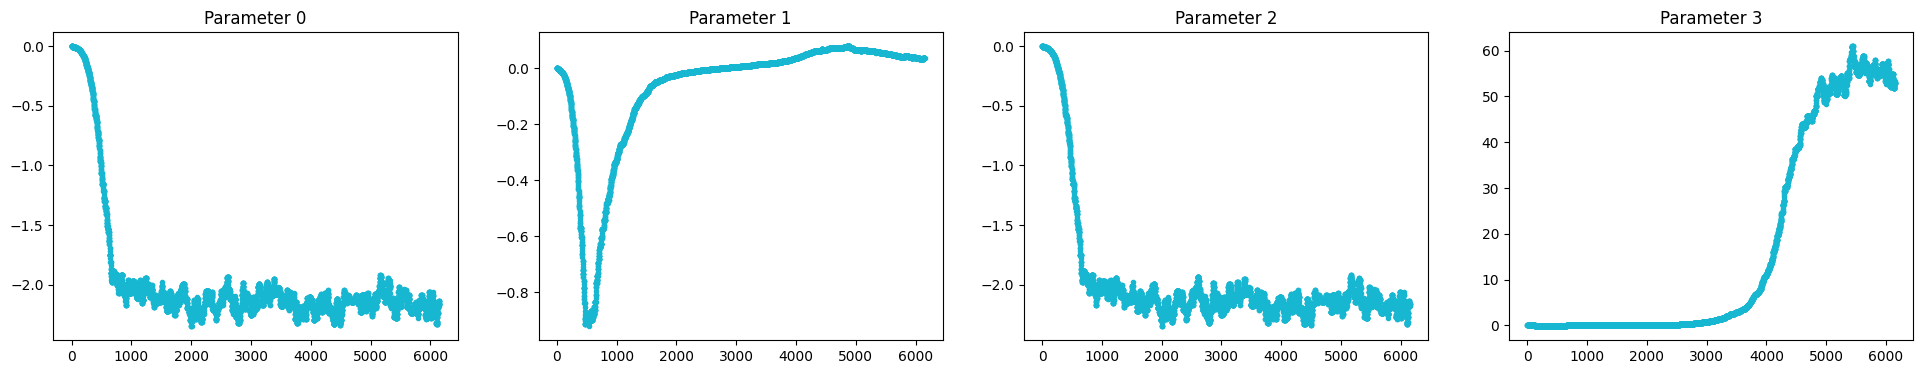

In [6]:
plot_params_iterations(params_no_ac)

In [7]:
params_estimate = torch.stack(params_no_ac[-1000:]).mean(axis = 0)
params_estimate

tensor([-2.1474e+00,  4.6938e-02, -2.1474e+00,  5.5138e+01],
       dtype=torch.float64)

In [8]:

algebraic_conn = torch.tensor([0])

new_params = torch.cat((params_estimate, algebraic_conn), dim=0)
new_params

tensor([-2.1474e+00,  4.6938e-02, -2.1474e+00,  5.5138e+01,  0.0000e+00],
       dtype=torch.float64)

In [9]:
observables_no_ac, graphs_no_ac = sampler_no_ac.sample_run(graph=ordmat,
                      observables=obs_no_ac,
                      params=params_estimate,
                      niter=niter_sampling,
                      save_every=50)

100%|██████████| 200000/200000 [01:04<00:00, 3121.13it/s]

number of accepted steps is:  36166
number of rejected samples:  163834
Mean obs:  tensor([40.3156,  7.2270,  2.6877,  0.1432], dtype=torch.float64)


In [10]:
connected_graphs_no_ac, connected_observables_no_ac = connected_graphs(sampler_no_ac, graphs_no_ac, max_components=1)

print(f"Fraction of connected graphs (no ac): {len(connected_graphs_no_ac)} over {len(graphs_no_ac)} sampled")

Fraction of connected graphs (no ac): 463 over 4281 sampled


In [12]:
class MHSampler(MHSampler):
    def __init__(self, backend: str):
        super().__init__(backend)

    def observables(self,mtx):
        
        L = laplacian_matrix(mtx)
        a3 = torch.matmul(torch.matmul(mtx,mtx),mtx)

        edges = torch.sum(mtx)/2
        triangles = torch.trace(a3)/6
        ac = torch.linalg.eigvalsh(L)[1]
        deg = torch.diagonal(L)
        tri_diag = torch.diagonal(a3) / 2

        valid = deg > 1
        local_clust = torch.zeros_like(deg)
        local_clust[valid] = tri_diag[valid] / (deg[valid] * (deg[valid] - 1))
        avg_clustering = torch.mean(local_clust[valid])

        avg_degree = torch.sum(mtx, dim=1).mean()

        return(torch.stack([edges, triangles, avg_degree, avg_clustering, ac]))

ac_sampler = MHSampler(backend="cuda")


CUDA backend not available falling back to cpu


In [13]:
obs_with_ac = ac_sampler.observables(ordmat)
obs_with_ac

tensor([41.0000,  6.0000,  2.7333,  0.1304,  0.2121], dtype=torch.float64)

In [14]:
mod_params = new_params + torch.tensor([0., 0., 0., 0., 10.])

In [15]:
params_estimate, mod_params

(tensor([-2.1474e+00,  4.6938e-02, -2.1474e+00,  5.5138e+01],
        dtype=torch.float64),
 tensor([-2.1474e+00,  4.6938e-02, -2.1474e+00,  5.5138e+01,  1.0000e+01],
        dtype=torch.float64))

In [16]:
observables_ac, graphs_ac = ac_sampler.sample_run(graph=ordmat,
                      observables=obs_with_ac,
                      params=mod_params,
                      niter=niter_sampling,
                      save_every=50)

100%|██████████| 200000/200000 [01:57<00:00, 1704.67it/s]

number of accepted steps is:  46382
number of rejected samples:  153618
Mean obs:  tensor([52.7996, 10.3400,  3.5200,  0.1138,  0.4644], dtype=torch.float64)


In [17]:
connected_graphs_ac, connected_observables_ac = connected_graphs(ac_sampler, graphs_ac, max_components=1)

print(f"Fraction of connected graphs: {len(connected_graphs_ac)} over {len(graphs_ac)} sampled")

Fraction of connected graphs: 3247 over 3862 sampled


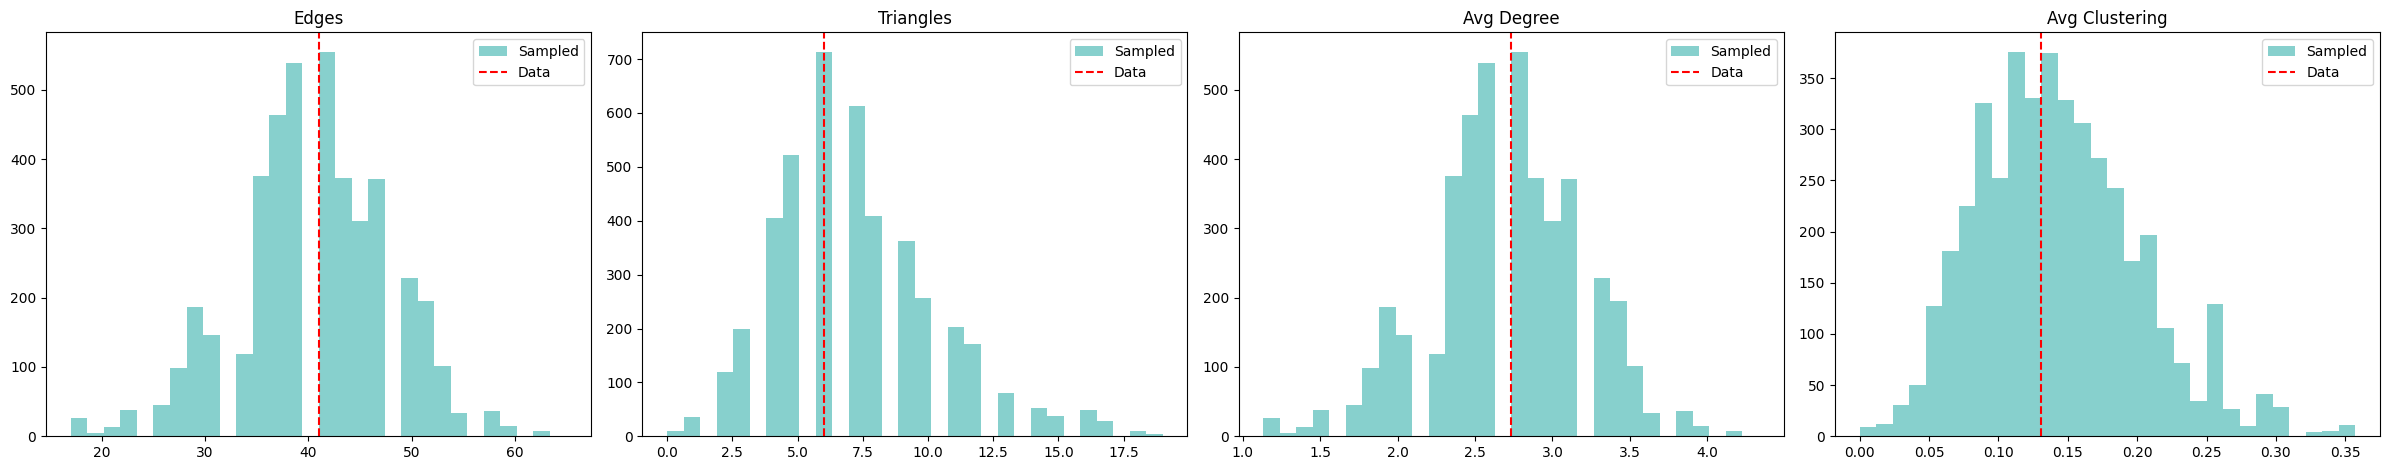

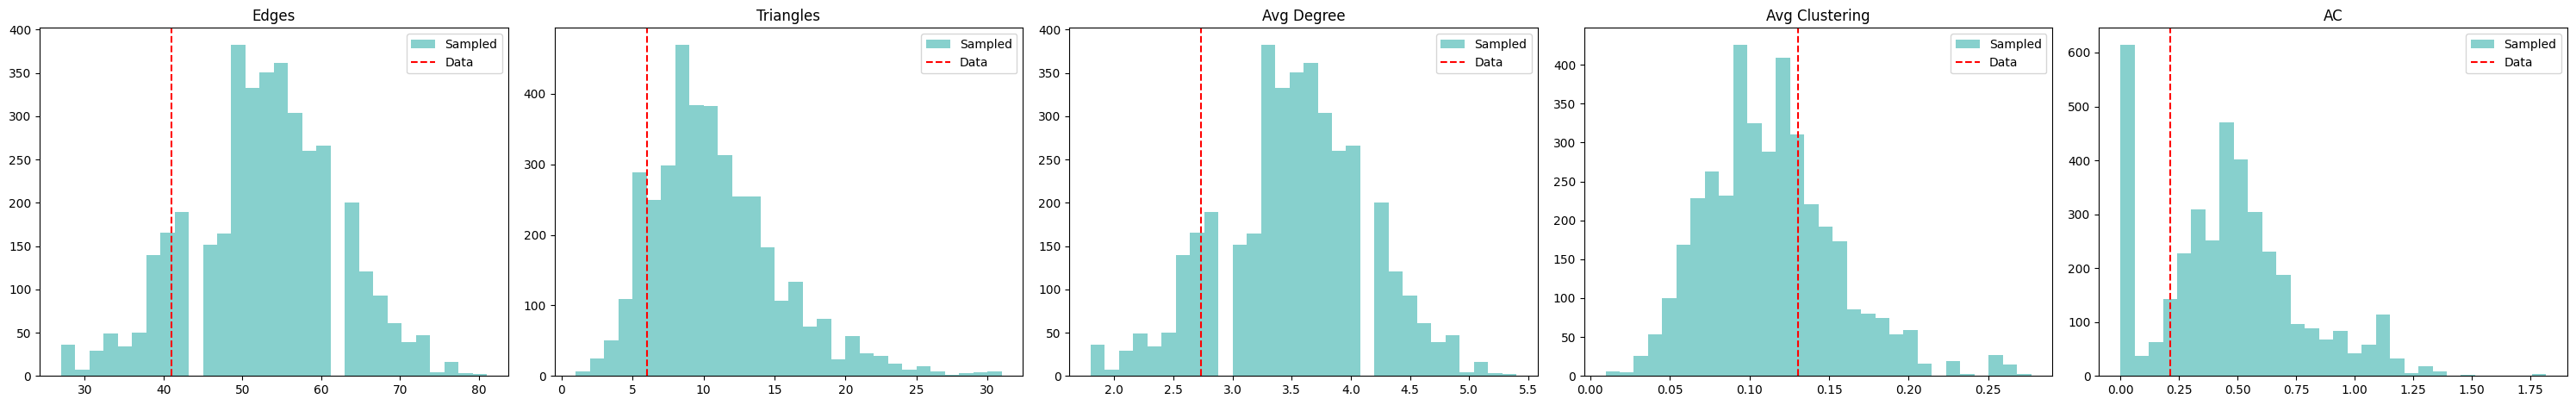

In [18]:
hist_obs_samples(observables_no_ac, obs_no_ac, obs_labels = ['Edges', 'Triangles', 'Avg Degree', 'Avg Clustering'])
hist_obs_samples(observables_ac, obs_with_ac, obs_labels = ['Edges', 'Triangles', 'Avg Degree', 'Avg Clustering', 'AC'])

In [50]:
mods = [0, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

observable_runs = []
graph_runs = []
number_of_connected = []
number_of_sampled = []

for i in range(len(mods)):
    mod_params = new_params + torch.tensor([0., 0., 0., 0., mods[i]])
    observables_ac, graphs_ac = ac_sampler.sample_run(graph=ordmat,
                          observables=obs_with_ac,
                          params=mod_params,
                          niter=niter_sampling,
                          save_every=50)
                          
    connected_graphs_ac, connected_observables_ac = connected_graphs(ac_sampler, graphs_ac, max_components=1)
    observable_runs.append(observables_ac)
    graph_runs.append(graphs_ac)
    number_of_connected.append(len(connected_graphs_ac))
    number_of_sampled.append(len(graphs_ac))

    print(f"Mod: {mods[i]} - Fraction of connected graphs: {len(connected_graphs_ac)} over {len(graphs_ac)} sampled")

100%|██████████| 200000/200000 [01:33<00:00, 2130.74it/s]


number of accepted steps is:  35135
number of rejected samples:  164865
Mean obs:  tensor([3.8745e+01, 6.8909e+00, 2.5830e+00, 1.5218e-01, 2.2086e-02],
       dtype=torch.float64)
Mod: 0 - Fraction of connected graphs: 358 over 4318 sampled


100%|██████████| 200000/200000 [01:16<00:00, 2599.39it/s]


number of accepted steps is:  17447
number of rejected samples:  182553
Mean obs:  tensor([2.1722e+01, 3.3732e+00, 1.4481e+00, 3.5868e-01, 5.3065e-03],
       dtype=torch.float64)
Mod: 0.0001 - Fraction of connected graphs: 68 over 3754 sampled


100%|██████████| 200000/200000 [01:31<00:00, 2184.88it/s]


number of accepted steps is:  34934
number of rejected samples:  165066
Mean obs:  tensor([3.8123e+01, 6.6006e+00, 2.5415e+00, 1.4847e-01, 1.8072e-02],
       dtype=torch.float64)
Mod: 0.001 - Fraction of connected graphs: 294 over 4021 sampled


100%|██████████| 200000/200000 [01:28<00:00, 2260.71it/s]


number of accepted steps is:  34494
number of rejected samples:  165506
Mean obs:  tensor([3.7884e+01, 6.7220e+00, 2.5256e+00, 1.6097e-01, 1.4047e-02],
       dtype=torch.float64)
Mod: 0.01 - Fraction of connected graphs: 205 over 3943 sampled


100%|██████████| 200000/200000 [01:30<00:00, 2220.64it/s]


number of accepted steps is:  35095
number of rejected samples:  164905
Mean obs:  tensor([3.8696e+01, 6.6152e+00, 2.5798e+00, 1.4671e-01, 2.1806e-02],
       dtype=torch.float64)
Mod: 0.1 - Fraction of connected graphs: 321 over 4067 sampled


100%|██████████| 200000/200000 [01:29<00:00, 2235.32it/s]


number of accepted steps is:  34286
number of rejected samples:  165714
Mean obs:  tensor([3.8116e+01, 6.5720e+00, 2.5410e+00, 1.5705e-01, 3.0066e-02],
       dtype=torch.float64)
Mod: 1 - Fraction of connected graphs: 408 over 3792 sampled


100%|██████████| 200000/200000 [01:35<00:00, 2099.42it/s]


number of accepted steps is:  44521
number of rejected samples:  155479
Mean obs:  tensor([50.1768,  9.6556,  3.3451,  0.1236,  0.3989], dtype=torch.float64)
Mod: 10 - Fraction of connected graphs: 2993 over 4236 sampled


100%|██████████| 200000/200000 [01:16<00:00, 2628.06it/s]


number of accepted steps is:  8892
number of rejected samples:  191108
Mean obs:  tensor([4.1019e+02, 3.3967e+03, 2.7346e+01, 4.6933e-01, 2.6727e+01],
       dtype=torch.float64)
Mod: 100 - Fraction of connected graphs: 3943 over 3943 sampled


In [51]:
mods, number_of_connected, number_of_sampled

([0, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
 [358, 68, 294, 205, 321, 408, 2993, 3943],
 [4318, 3754, 4021, 3943, 4067, 3792, 4236, 3943])

Text(0, 0.5, 'Number of Graphs')

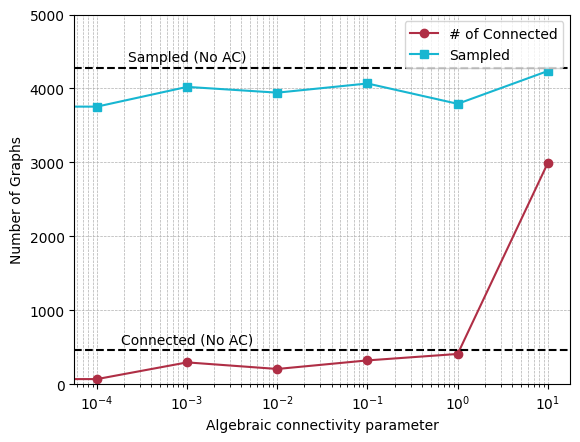

In [53]:
plt.plot(mods[:-1], number_of_connected[:-1], marker="o", label="# of Connected", color='#af2e45')
plt.plot(mods[:-1], number_of_sampled[:-1], marker="s", label="Sampled", color='#17B6D1')
plt.ylim(0, 5000)
plt.axhline(y=len(connected_graphs_no_ac), color='black', linestyle='--')
plt.axhline(y=len(graphs_no_ac), color='black', linestyle='--')
plt.text(
    x=10e-4, y=len(graphs_no_ac)+50,
    s="Sampled (No AC)", color="black",
    ha="center", va="bottom"
)
plt.text(
    x=0.001, y=len(connected_graphs_no_ac)+50,
    s="Connected (No AC)", color="black",
    ha="center", va="bottom"
)
plt.legend()

plt.xscale("log")
plt.grid(True, which="both", ls="--", lw=0.5)
plt.xlabel("Algebraic connectivity parameter")
plt.ylabel("Number of Graphs")